# Deep Dive: Using EM Segmentation Data

This comprehensive tutorial explores the powerful segmentation capabilities of CRANTpy using CAVE. We'll cover:

1. **Root and supervoxel conversions** - Working with different segmentation levels
2. **Location-based queries** - Finding segmentation at specific coordinates
3. **ID updates and validation** - Keeping root IDs current
4. **Neuron mapping** - Connecting spatial data to segmentation
5. **Voxel operations** - Working with voxel-level data
6. **Temporal analysis** - Understanding segmentation history
7. **Spatial corrections** - Snapping coordinates to segmentation

These tools are essential for working with dynamic segmentation data in CAVE/ChunkedGraph systems.

Let's get started by setting up our environment.

In [1]:
# Import CRANTpy and other necessary libraries
import crantpy as cp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import navis

# Set up logging to see progress
cp.set_logging_level("WARNING")  # Quieter for this tutorial

print("CRANTpy loaded successfully!")
print(f"Default dataset: {cp.CRANT_DEFAULT_DATASET}")

CRANTpy loaded successfully!
Default dataset: latest


## 1. Authentication Setup

Before we can access the data, we need to authenticate with the CAVE service. This is typically a one-time setup.

In [2]:
# Generate and save authentication token (uncomment if first time)
# cp.generate_cave_token(save=True)

# Test connection
try:
    client = cp.get_cave_client()
    print(f"Successfully connected to datastack: {client.datastack_name}")
    print(f"Server: {client.server_address}")
except Exception as e:
    print(f"Connection failed: {e}")
    print("Please run: cp.generate_cave_token(save=True)")

Successfully connected to datastack: kronauer_ant
Server: https://proofreading.zetta.ai


## 2. Root IDs and Supervoxels

CAVE segmentation has a hierarchical structure:
- **Supervoxels** - The smallest atomic units (never change)
- **L2 chunks** - Groups of supervoxels
- **Root IDs** - The top-level segments that represent neurons (can change with edits)

Understanding this hierarchy is crucial for working with dynamic segmentation.

### Converting Root IDs to Supervoxels

Supervoxels are stable - they never change even when neurons are edited. This makes them useful for tracking neurons over time.

In [3]:
# Get some example neurons
example_neurons = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', proofread=True)
example_ids = example_neurons.get_roots()[:3]  # Get first 3
print(f"Example root IDs: {example_ids}")

# Convert to supervoxels
sv_dict = cp.roots_to_supervoxels(example_ids)

print(f"Supervoxel breakdown:")
for root_id, supervoxels in sv_dict.items():
    print(f"  Root {root_id}: {len(supervoxels):,} supervoxels")
    print(f"    First 5: {supervoxels[:5]}")
    print()

Example root IDs: ['576460752681552812' '576460752773799604' '576460752656800770']


Querying:   0%|          | 0/3 [00:00<?, ?it/s]

Supervoxel breakdown:
  Root 576460752656800770: 155,486 supervoxels
    First 5: [74873375269027774 74873375268949798 74873375268996643 74873375268993836
 74873375268949820]

  Root 576460752681552812: 100,119 supervoxels
    First 5: [74310013535161003 74310013535166331 74310013535158359 74310013535158357
 74310013535158351]

  Root 576460752773799604: 115,050 supervoxels
    First 5: [74239507016850136 74239507016847407 74239507016839180 74239507016836277
 74239507016836287]



### Converting Supervoxels to Root IDs

You can also go the other direction - from supervoxels to root IDs. This is useful for finding which neuron a supervoxel belongs to.

In [4]:
print(f"Starting root ID: {int(example_ids[0])}")

# Take some supervoxels from our first neuron
sample_supervoxels = sv_dict[int(example_ids[0])][:10]
print(f"\nSample supervoxels: {sample_supervoxels}")

# Convert back to root IDs
roots_from_sv = cp.supervoxels_to_roots(sample_supervoxels)
print(f"\nRoot IDs from supervoxels: {roots_from_sv}")
print(f"All belong to same root? {np.all(roots_from_sv == int(example_ids[0]))}")

# You can also query at a specific time
print("\n--- Time-based queries ---")
roots_current = cp.supervoxels_to_roots(sample_supervoxels, timestamp="mat")
print(f"Current root IDs: {np.unique(roots_current)}")

Starting root ID: 576460752681552812

Sample supervoxels: [74310013535161003 74310013535166331 74310013535158359 74310013535158357
 74310013535158351 74310013535155583 74239575668933333 74239575668922938
 74239575668839596 74239575668689743]

Root IDs from supervoxels: [576460752681552812 576460752681552812 576460752681552812
 576460752681552812 576460752681552812 576460752681552812
 576460752681552812 576460752681552812 576460752681552812
 576460752681552812]
All belong to same root? True

--- Time-based queries ---
Current root IDs: [576460752681552812]


## 3. Location-Based Segmentation Queries

One of the most useful operations is finding which segment exists at a specific x/y/z location.

### Finding Supervoxels at Locations

Get the supervoxel ID at specific coordinates.

In [5]:
# first lets get the location of a random l2 node from each of our example neurons
locations = []
for i in range(len(example_ids)):
    skel = cp.get_l2_skeleton(example_ids)
    # pick a random index from the node list
    index = np.random.choice(skel.nodes.index)
    # get the location of the l2 node and
    locations.append(skel.nodes.loc[index,['x','y','z']].values)
locations = np.array(locations)

Fetching L2 skeletons:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching L2 skeletons:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching L2 skeletons:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:

print(f"Querying {len(locations)} locations...")

# Get supervoxel IDs at these locations
supervoxels_at_locs = cp.locs_to_supervoxels(
    locations, 
    coordinates="nm",
    mip=0  # Highest resolution
)

print(f"\nSupervoxel IDs at locations:")
for i, (loc, sv_id) in enumerate(zip(locations, supervoxels_at_locs)):
    print(f"  Location {i+1} {loc}: supervoxel {sv_id}")

# You can also use DataFrames
loc_df = pd.DataFrame(locations, columns=['x', 'y', 'z'])
supervoxels_df = cp.locs_to_supervoxels(loc_df, coordinates="nm")
loc_df['supervoxel_id'] = supervoxels_df
print("\nLocations DataFrame:")
display(loc_df)

Querying 3 locations...


Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]


Supervoxel IDs at locations:
  Location 1 [np.float64(331200.0) np.float64(93376.0) np.float64(112812.0)]: supervoxel 74732225463459004
  Location 2 [np.float64(305488.0) np.float64(107744.0) np.float64(186312.0)]: supervoxel 74521257139550053
  Location 3 [np.float64(254752.0) np.float64(236672.0) np.float64(75222.0)]: supervoxel 74100074728972648


Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]


Locations DataFrame:


,x,y,z,supervoxel_id
0,331200.0,93376.0,112812.0,74732225463459004
1,305488.0,107744.0,186312.0,74521257139550053
2,254752.0,236672.0,75222.0,74100074728972648


### Finding Root IDs (Segments) at Locations

More commonly, you want to know which neuron (root ID) is at a location.

In [7]:
# Get root IDs at the same locations
root_ids_at_locs = cp.locs_to_segments(
    locations,
    coordinates="nm",
    timestamp="mat"  # Use latest materialization
)

print(f"Root IDs at locations:")
for i, (loc, root_id) in enumerate(zip(locations, root_ids_at_locs)):
    print(f"  Location {i+1} {loc}: root ID {root_id}")

# Check if any locations hit the same neuron
unique_roots = np.unique(root_ids_at_locs[root_ids_at_locs != 0])
print(f"\nFound {len(unique_roots)} unique neurons at these locations")

# Get annotations for these neurons
if len(unique_roots) > 0:
    annotations = cp.get_annotations(unique_roots)
    print("\nNeurons found at locations:")
    display(annotations[['root_id', 'cell_class', 'cell_type', 'side']].head(unique_roots.size))

Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]

Root IDs at locations:
  Location 1 [np.float64(331200.0) np.float64(93376.0) np.float64(112812.0)]: root ID 576460752681552812
  Location 2 [np.float64(305488.0) np.float64(107744.0) np.float64(186312.0)]: root ID 576460752656800770
  Location 3 [np.float64(254752.0) np.float64(236672.0) np.float64(75222.0)]: root ID 576460752681552812

Found 2 unique neurons at these locations

Neurons found at locations:


,root_id,cell_class,cell_type,side
1,576460752681552812,olfactory_projection_neuron,None,left
5,576460752656800770,olfactory_projection_neuron,None,right


## 4. Updating and Validating Root IDs

Root IDs can become outdated as neurons are edited (merged/split). CRANTpy provides tools to check and update IDs.

### Validating Root IDs

Check if root IDs are valid and current.

In [8]:
# Check if root IDs are valid
test_ids = example_ids[:5]
print(f"Testing {len(test_ids)} root IDs...")

# Check validity
is_valid = cp.is_valid_root(test_ids)
print(f"\nValidity check:")
for root_id, valid in zip(test_ids, is_valid):
    status = "✓ Valid" if valid else "✗ Invalid"
    print(f"  {root_id}: {status}")

# Check if they're the latest version
is_latest = cp.is_latest_roots(test_ids)
print(f"\nLatest check:")
for root_id, latest in zip(test_ids, is_latest):
    status = "✓ Current" if latest else "✗ Outdated"
    print(f"  {root_id}: {status}")

# Summary
print(f"\nSummary: {np.sum(is_valid)}/{len(test_ids)} valid, {np.sum(is_latest)}/{len(test_ids)} current")

Testing 3 root IDs...

Validity check:
  576460752681552812: ✓ Valid
  576460752773799604: ✓ Valid
  576460752656800770: ✓ Valid

Latest check:
  576460752681552812: ✓ Current
  576460752773799604: ✓ Current
  576460752656800770: ✓ Current

Summary: 3/3 valid, 3/3 current


### Updating Outdated Root IDs

If you have outdated root IDs, you can update them to the current version.

In [9]:
# Update root IDs to latest version
update_result = cp.update_ids(test_ids, progress=True)

print("Update results:")
display(update_result)

# Check which IDs changed
changed = update_result[update_result['changed']]
if len(changed) > 0:
    print(f"\n{len(changed)} IDs were updated:")
    display(changed)
else:
    print("\n✓ All IDs were already current!")

# Update with supervoxels (much faster if you have them)
print("\n--- Using supervoxels for faster updates ---")
# If you have supervoxels saved from earlier
if len(sv_dict) > 0:
    # Get the first root from sv_dict
    first_root = list(sv_dict.keys())[0]
    
    # Get first supervoxel and ensure it's a Python int
    # sv_dict[root_id] returns an array of supervoxels
    first_sv_array = sv_dict[first_root]
    if len(first_sv_array) > 0:
        first_sv = int(first_sv_array[0])
        
        print(f"Testing with root ID: {first_root}, supervoxel: {first_sv}")
        
        try:
            update_with_sv = cp.update_ids(
                [int(first_root)],  # Ensure root is also int
                supervoxels=[first_sv],
                progress=False
            )
            print("\nUpdate with supervoxel:")
            display(update_with_sv)
        except Exception as e:
            print(f"\nError during update with supervoxel: {e}")
    else:
        print("No supervoxels found for first root")
else:
    print("No supervoxels available in sv_dict")

2025-10-04 16:11:23 - WARNING - Multiple supervoxel IDs found for 130 root IDs. Using first occurrence for each.


Update results:


,old_id,new_id,confidence,changed
0,576460752681552812,576460752681552812,1.0,False
1,576460752773799604,576460752773799604,1.0,False
2,576460752656800770,576460752656800770,1.0,False



✓ All IDs were already current!

--- Using supervoxels for faster updates ---
Testing with root ID: 576460752656800770, supervoxel: 74873375269027774

Update with supervoxel:


,old_id,new_id,confidence,changed
0,576460752656800770,576460752656800770,1.0,False


## 5. Mapping Neurons to Segmentation

If you have neuron reconstructions (skeletons), you can find which root IDs they overlap with.

### Finding Overlapping Segments

This is useful for:
- Validating that a skeleton matches the expected segmentation
- Finding which segments a tracing overlaps with
- Quality control of reconstructions

In [10]:
# For this example, we'll create a simple synthetic neuron
# In practice, you would load your actual neuron data

center_location = locations[0]  # Use the first location from earlier
spread = 2000  # Spread of the synthetic neuron

# Create a simple TreeNeuron with nodes in your space
nodes_data = pd.DataFrame({
    'node_id': range(20),
    'x': np.linspace(center_location[0] - spread, center_location[0] + spread, 20),
    'y': np.linspace(center_location[1] - spread, center_location[1] + spread, 20),
    'z': np.linspace(center_location[2] - spread, center_location[2] + spread, 20),
    'parent_id': [-1] + list(range(19))
})

test_neuron = navis.TreeNeuron(nodes_data, units='nm')
print(f"Created test neuron with {len(test_neuron.nodes)} nodes")

# Find which segments overlap with this neuron
overlap_summary = cp.neuron_to_segments(
    test_neuron,
    short=True,  # Just get top match
    coordinates="nm"
)

print("\nBest matching segment:")
display(overlap_summary)

# Get full overlap matrix
overlap_matrix = cp.neuron_to_segments(
    test_neuron,
    short=False,
    coordinates="nm"
)

print("\nFull overlap matrix:")
print(f"Shape: {overlap_matrix.shape}")
display(overlap_matrix)

Created test neuron with 20 nodes


Fetching supervoxels:   0%|          | 0/20 [00:00<?, ?it/s]


Best matching segment:


,id,match,confidence
0,6a033bea-6948-4e10-9229-431c8f5e7a22,576460752681552812,0.1


Fetching supervoxels:   0%|          | 0/20 [00:00<?, ?it/s]


Full overlap matrix:
Shape: (13, 1)


id,6a033bea-6948-4e10-9229-431c8f5e7a22
root_id,
576460752502203165,1
576460752502255389,1
576460752551876313,1
576460752552099545,1
576460752552427737,1
576460752642804358,1
576460752679586871,3
576460752681552812,5
576460752693418619,2


## 6. Segmentation Cutouts

You can extract a 3D volume of segmentation data in a bounding box.

### Extracting a Volume of Segmentation

This is useful for:
- Analyzing local connectivity
- Visualizing segmentation in 3D
- Finding all segments in a region

Fetching segmentation cutout...
Bounding box (nm):
  X: [329200. 333200.]
  Y: [91376. 95376.]
  Z: [112712. 112912.]

Cutout info:
  Shape: (124, 124, 4)
  Resolution: [32 32 42] nm/voxel
  Offset: [329216  91392 112728] nm

Found 311 unique segments in this volume
Segment IDs: [576460752499537597 576460752502187549 576460752502203933
 576460752502220317 576460752502236445 576460752502254877
 576460752502268701 576460752502268957 576460752502275869
 576460752502276893]...


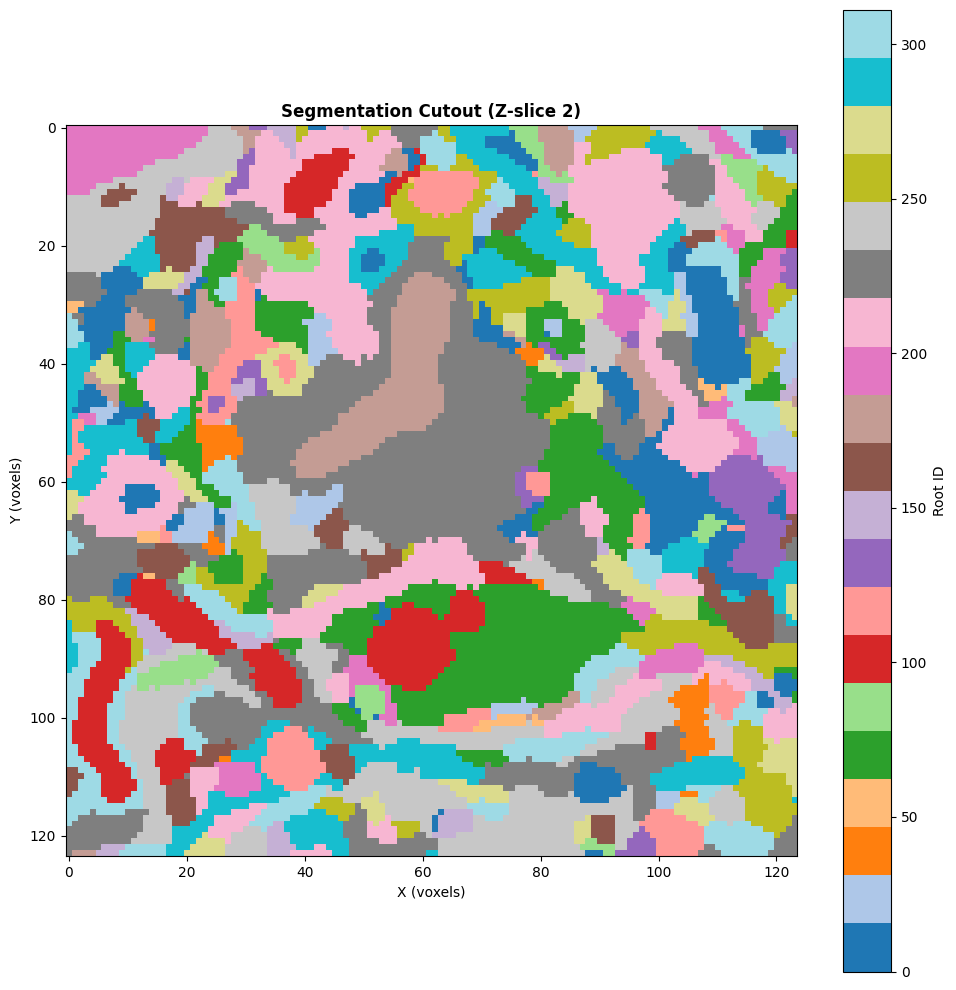

In [11]:
# Define a small bounding box (in nanometers)
# Format: [[xmin, xmax], [ymin, ymax], [zmin, zmax]]

# create a box around the center_location
bbox = np.array([
    [center_location[0] - 2000, center_location[0] + 2000],
    [center_location[1] - 2000, center_location[1] + 2000],
    [center_location[2] - 100, center_location[2] + 100]
])

print(f"Fetching segmentation cutout...")
print(f"Bounding box (nm):")
print(f"  X: {bbox[0]}")
print(f"  Y: {bbox[1]}")
print(f"  Z: {bbox[2]}")

# Get the cutout with root IDs
cutout, resolution, offset = cp.get_segmentation_cutout(
    bbox,
    root_ids=True,  # Get root IDs (not supervoxels)
    mip=1,          # Lower resolution for faster fetching
    coordinates="nm"
)

print(f"\nCutout info:")
print(f"  Shape: {cutout.shape}")
print(f"  Resolution: {resolution} nm/voxel")
print(f"  Offset: {offset} nm")

# Find unique segments in this volume
unique_segments = np.unique(cutout)
unique_segments = unique_segments[unique_segments != 0]  # Remove background
print(f"\nFound {len(unique_segments)} unique segments in this volume")
print(f"Segment IDs: {unique_segments[:10]}...")  # Show first 10

# map the values to a contiguous range for better visualization
if len(unique_segments) > 0:
    segment_map = {seg_id: i+1 for i, seg_id in enumerate(unique_segments)}
    vectorized_map = np.vectorize(lambda x: segment_map.get(x, 0))
    cutout = vectorized_map(cutout)

# Visualize a slice
if cutout.shape[2] > 0:
    mid_z = cutout.shape[2] // 2
    plt.figure(figsize=(10, 10))
    plt.imshow(cutout[:, :, mid_z].T, cmap='tab20', interpolation='nearest')
    plt.title(f'Segmentation Cutout (Z-slice {mid_z})', fontsize=12, fontweight='bold')
    plt.xlabel('X (voxels)')
    plt.ylabel('Y (voxels)')
    plt.colorbar(label='Root ID')
    plt.tight_layout()
    plt.show()

## 7. Voxel-Level Operations

Work with individual voxels that make up a neuron.

### Getting All Voxels for a Neuron

This retrieves all voxel coordinates that belong to a specific root ID within a specified region.

**⚠️ Important: CloudVolume Coverage and Resolution**

When working with voxel-level data, keep in mind:

- **Limited Spatial Coverage**: CloudVolume contains only a subset (~360 x 344 x 257 µm) of the full CAVE dataset
- **Resolution Mismatch**: CloudVolume's highest resolution (MIP 0) is 16x16x42 nm/voxel, which is 2x coarser than CAVE's base resolution (8x8x42 nm/voxel)
- **Coordinate Systems**: CAVE uses nanometers, CloudVolume uses voxels at the current MIP level

**Best Practices:**
1. **Always provide explicit bounds** within CloudVolume coverage to avoid errors
2. **Use small regions** (< 10 µm) for voxel queries - large regions can be slow
3. **Test bounds first** using `get_segmentation_cutout` before fetching voxels
4. **For full neurons**: Use L2 skeletons (`get_l2_skeleton`) or meshes (`get_mesh`) instead of voxels
5. **Choose appropriate MIP**: Use MIP 1 for faster queries when precise resolution isn't critical

In [12]:
# Get voxels for one of our example neurons
target_id = example_ids[0]
print(f"Fetching voxels for root ID: {target_id}")

# Define a small region around a known location within CloudVolume coverage
# Using center_location from earlier (which we know is within bounds)
bounds = np.array([
    [center_location[0] - 2000, center_location[0] + 2000],  # 4 µm window in X
    [center_location[1] - 2000, center_location[1] + 2000],  # 4 µm window in Y
    [center_location[2] - 500, center_location[2] + 500]     # 1 µm window in Z
])

print(f"\nBounds (in nm):")
print(f"  X: [{bounds[0,0]:.0f}, {bounds[0,1]:.0f}]")
print(f"  Y: [{bounds[1,0]:.0f}, {bounds[1,1]:.0f}]")
print(f"  Z: [{bounds[2,0]:.0f}, {bounds[2,1]:.0f}]")

# Method 1: Get voxels without supervoxel mapping (faster)
print("\n--- Getting voxels (without supervoxel mapping) ---")
voxels = cp.get_voxels(
    target_id,
    mip=1,  # Lower resolution for speed
    bounds=bounds,
    use_l2_chunks=False,  # Use cutout method
    sv_map=False,  # Don't map to supervoxels
    progress=True
)

if len(voxels) > 0:
    print(f"\n✓ Retrieved {len(voxels):,} voxels")
    print(f"  Voxel ranges:")
    print(f"    X: [{voxels[:, 0].min()}, {voxels[:, 0].max()}]")
    print(f"    Y: [{voxels[:, 1].min()}, {voxels[:, 1].max()}]")
    print(f"    Z: [{voxels[:, 2].min()}, {voxels[:, 2].max()}]")
    
    # Method 2: Get voxels WITH supervoxel mapping
    print("\n--- Getting voxels (with supervoxel mapping) ---")
    voxels_sv, sv_ids = cp.get_voxels(
        target_id,
        mip=1,
        bounds=bounds,
        use_l2_chunks=False,
        sv_map=True,  # Map each voxel to its supervoxel ID
        progress=True
    )
    
    print(f"\n✓ Retrieved {len(voxels_sv):,} voxels")
    print(f"  Number of unique supervoxels: {len(np.unique(sv_ids)):,}")
    print(f"  Sample supervoxel IDs: {np.unique(sv_ids)[:5]}")
else:
    print("\n⚠️ No voxels found in this region")
    print("  This neuron may not have coverage in CloudVolume at this location")


Fetching voxels for root ID: 576460752681552812

Bounds (in nm):
  X: [329200, 333200]
  Y: [91376, 95376]
  Z: [112312, 113312]

--- Getting voxels (without supervoxel mapping) ---

✓ Retrieved 22,377 voxels
  Voxel ranges:
    X: [10314, 10400]
    Y: [2856, 2957]
    Z: [2674, 2697]

--- Getting voxels (with supervoxel mapping) ---

✓ Retrieved 22,377 voxels
  Number of unique supervoxels: 457
  Sample supervoxel IDs: [74732225463411215 74732225463419220 74732225463419226 74732225463419260
 74732225463421800]


## 8. Spatial Coordinate Correction

Sometimes your coordinates might not exactly hit the neuron you expect. You can "snap" them to the nearest voxel with the correct ID.

### Snapping Coordinates to Segmentation

This is useful for:
- Correcting slightly misaligned annotations
- Ensuring synapses are on the correct neuron
- Quality control of coordinate data

In [13]:
# Demonstration of snap_to_id functionality
# Note: This function requires CloudVolume coverage at the target locations

target_id = example_ids[0]
print(f"Target neuron: {target_id}")

# Create test locations near a region we know has data
# Make larger offsets to simulate imprecise annotations
test_locs = np.array([
    center_location + np.array([-500, -500, 0]),
    center_location + np.array([-500, 500, 0]),
    center_location + np.array([500, -500, 0])
], dtype=float)

print(f"\nTest locations (with larger offsets to show snapping):")
for i, loc in enumerate(test_locs):
    print(f"  Location {i+1}: {loc}")

# Check what segments these locations currently hit
print(f"\nChecking current segmentation:")
current_segments = cp.locs_to_segments(test_locs, coordinates="nm")

# Find which segment is at the center location (our target)
target_segment = cp.locs_to_segments([center_location], coordinates="nm")[0]
print(f"\nTarget segment at center: {target_segment}")

# Show what we got at test locations
for i, seg in enumerate(current_segments):
    match = "✓" if seg == target_segment else "✗"
    print(f"  Location {i+1}: segment {seg} {match}")

# Try to snap to the target segment
print(f"\nAttempting to snap all locations to segment: {target_segment}")

snapped_locs = cp.snap_to_id(
    test_locs,
    id=target_segment,
    search_radius=500,  # 500nm search radius
    coordinates="nm",
    verbose=True
)

# Verify
snapped_segments = cp.locs_to_segments(snapped_locs, coordinates="nm")
matches = snapped_segments == target_segment
print(f"\n✓ After snapping: {np.sum(matches)}/{len(snapped_locs)} on target segment")

# Calculate movement
movement = np.linalg.norm(snapped_locs - test_locs, axis=1)
successful = movement > 0
if np.sum(successful) > 0:
    print(f"\nMovement statistics:")
    print(f"  Successfully snapped: {np.sum(successful)}/{len(movement)}")
    print(f"  Mean movement: {np.mean(movement[successful]):.2f} nm")
    print(f"  Max movement: {np.max(movement):.2f} nm")
    print(f"  Min movement: {np.min(movement[successful]):.2f} nm")
else:
    print("\nNo locations needed snapping (all already correct)")

print("\n💡 snap_to_id is useful for:")
print("  - Correcting manually annotated synapse locations")
print("  - Fixing coordinates from image registration")  
print("  - Quality control of spatial annotations")


Target neuron: 576460752681552812

Test locations (with larger offsets to show snapping):
  Location 1: [330700.  92876. 112812.]
  Location 2: [330700.  93876. 112812.]
  Location 3: [331700.  92876. 112812.]

Checking current segmentation:


Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]

Fetching supervoxels:   0%|          | 0/1 [00:00<?, ?it/s]


Target segment at center: 576460752681552812
  Location 1: segment 576460752681552812 ✓
  Location 2: segment 576460752718331166 ✗
  Location 3: segment 576460752551830489 ✗

Attempting to snap all locations to segment: 576460752681552812


Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]

2 of 3 locations needed to be snapped.
Of these 0 locations could not be snapped - consider
increasing `search_radius`.



Fetching supervoxels:   0%|          | 0/3 [00:00<?, ?it/s]


✓ After snapping: 3/3 on target segment

Movement statistics:
  Successfully snapped: 2/3
  Mean movement: 233.14 nm
  Max movement: 382.08 nm
  Min movement: 84.19 nm

💡 snap_to_id is useful for:
  - Correcting manually annotated synapse locations
  - Fixing coordinates from image registration
  - Quality control of spatial annotations


## 9. Temporal Analysis: Edit History

CAVE segmentation is versioned - you can see how neurons have changed over time.

### Getting the Lineage Graph

The lineage graph shows all the edits (merges/splits) that led to the current version of a neuron.

Getting edit history for root ID: 576460752681552812

Lineage graph statistics:
  Number of versions: 134
  Number of operations: 133

Most recent versions (node IDs):
  576460752759576858
  576460752678850552
  576460752681107663
    Operation: 126
  576460752726458923
  576460752764825007


/var/folders/y6/xn2dyw2s14b79mrpmzrhykhc0000gn/T/ipykernel_46047/230392531.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


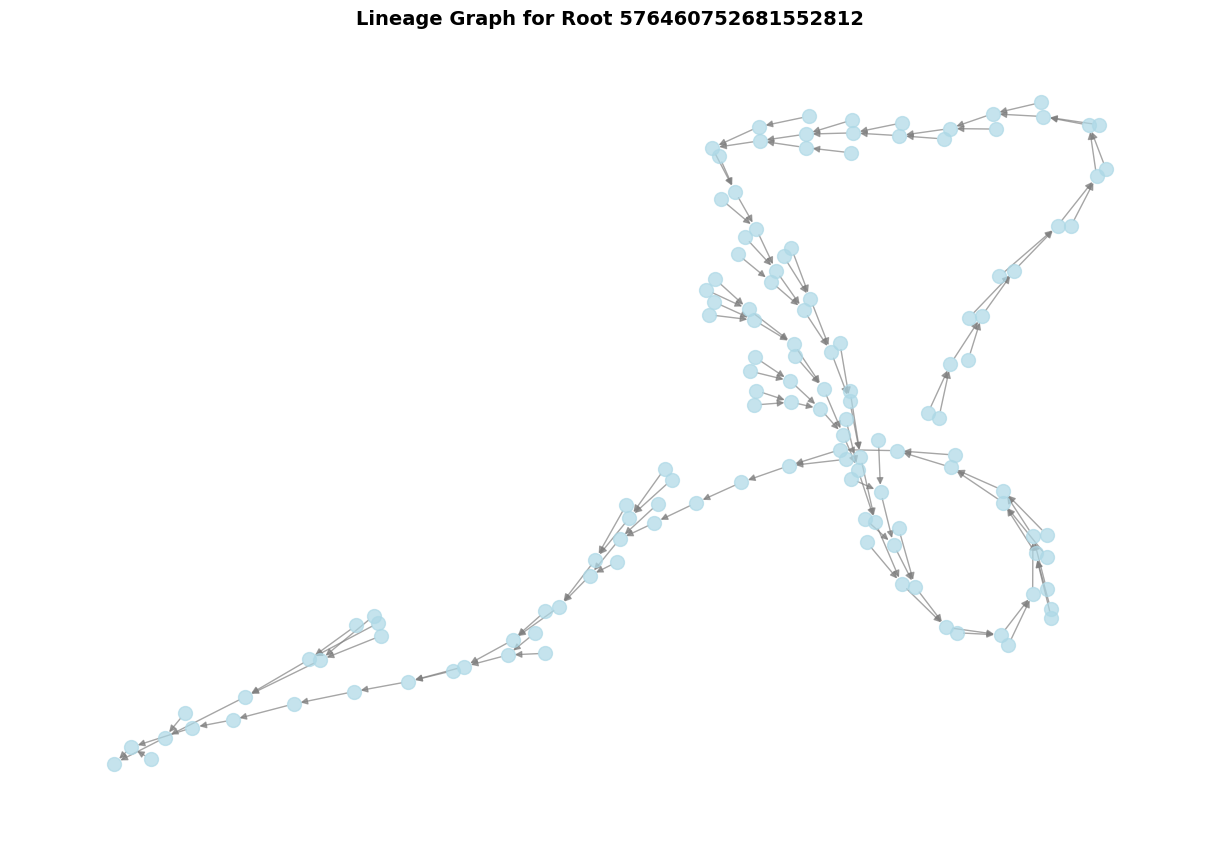

In [16]:
# Get lineage graph for a neuron
target_id = example_ids[0]
print(f"Getting edit history for root ID: {target_id}")

try:
    G = cp.get_lineage_graph(target_id)
    
    print(f"\nLineage graph statistics:")
    print(f"  Number of versions: {len(G.nodes())}")
    print(f"  Number of operations: {len(G.edges())}")
    
    # Show the most recent versions
    print(f"\nMost recent versions (node IDs):")
    recent_nodes = list(G.nodes())[-5:]  # Last 5 nodes
    for node in recent_nodes:
        print(f"  {node}")
        if 'operation_id' in G.nodes[node]:
            print(f"    Operation: {G.nodes[node]['operation_id']}")
    
    # Visualize the lineage graph
    import networkx as nx
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=1, iterations=1000)
    nx.draw(G, pos, 
            node_color='lightblue', 
            node_size=100,
            with_labels=False, 
            arrows=True,
            edge_color='gray',
            alpha=0.7)
    plt.title(f'Lineage Graph for Root {target_id}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"\nNote: Lineage graph requires proofreading history: {e}")

### Finding Common Time Points

If you're analyzing multiple neurons, you might want to find a time when they all existed in a particular state.

In [17]:
# Find a time when multiple neurons co-existed
test_ids = example_ids[:3]
print(f"Finding common time for {len(test_ids)} neurons...")

try:
    common_time = cp.find_common_time(test_ids)
    print(f"\nCommon time found: {common_time}")
    print(f"  Date: {common_time.strftime('%Y-%m-%d')}")
    print(f"  Time: {common_time.strftime('%H:%M:%S')}")
    
    # You can use this timestamp to query historical states
    print("\nYou can now query the state of these neurons at this time:")
    print(f"  cp.locs_to_segments(locations, timestamp={int(common_time.timestamp())})")
    
except ValueError as e:
    print(f"\nThese neurons never co-existed: {e}")
except Exception as e:
    print(f"\nNote: {e}")

Finding common time for 3 neurons...

Common time found: 2025-09-01 15:02:36.196459+00:00
  Date: 2025-09-01
  Time: 15:02:36

You can now query the state of these neurons at this time:
  cp.locs_to_segments(locations, timestamp=1756738956)


## 10. Practical Workflows

Let's combine these tools in some practical workflows.

### Workflow 1: Validating and Updating a List of Neurons

In [18]:
# Scenario: You have a list of neurons from an old analysis
old_neuron_list = example_ids[:10]

print(f"Working with {len(old_neuron_list)} neurons from previous analysis")

# Step 1: Check validity
print("\n1. Checking if IDs are valid...")
is_valid = cp.is_valid_root(old_neuron_list)
valid_ids = old_neuron_list[is_valid]
print(f"   ✓ {np.sum(is_valid)}/{len(old_neuron_list)} are valid root IDs")

if len(valid_ids) < len(old_neuron_list):
    print(f"   ✗ {len(old_neuron_list) - len(valid_ids)} invalid IDs removed")

# Step 2: Check if up-to-date
print("\n2. Checking if IDs are current...")
is_latest = cp.is_latest_roots(valid_ids)
print(f"   ✓ {np.sum(is_latest)}/{len(valid_ids)} are up-to-date")

# Step 3: Update outdated IDs
print("\n3. Updating outdated IDs...")
update_result = cp.update_ids(valid_ids, progress=False)
updated_ids = update_result['new_id'].values

# Step 4: Get supervoxels for stable tracking
print("\n4. Getting supervoxels for stable tracking...")
sv_dict = cp.roots_to_supervoxels(updated_ids[:3], progress=False)  # Just first 3 for demo
print(f"   ✓ Stored {len(sv_dict)} neurons with their supervoxels")

# Step 5: Save results
result_df = pd.DataFrame({
    'old_id': update_result['old_id'],
    'new_id': update_result['new_id'],
    'changed': update_result['changed'],
    'confidence': update_result['confidence']
})

print("\n5. Final results:")
display(result_df.head(10))
print(f"\nSummary: {result_df['changed'].sum()} neurons were updated")

Working with 3 neurons from previous analysis

1. Checking if IDs are valid...
   ✓ 3/3 are valid root IDs

2. Checking if IDs are current...
   ✓ 3/3 are up-to-date

3. Updating outdated IDs...


2025-10-04 16:13:09 - WARNING - Multiple supervoxel IDs found for 130 root IDs. Using first occurrence for each.



4. Getting supervoxels for stable tracking...
   ✓ Stored 3 neurons with their supervoxels

5. Final results:


,old_id,new_id,changed,confidence
0,576460752681552812,576460752681552812,False,1.0
1,576460752773799604,576460752773799604,False,1.0
2,576460752656800770,576460752656800770,False,1.0



Summary: 0 neurons were updated


### Workflow 2: Quality Control for Synapse Annotations

In [19]:
# Scenario: You have synapse locations and want to verify they're on the right neurons

# Get the actual segment at center_location (which we know has coverage)
target_neuron = cp.locs_to_segments([center_location], coordinates="nm")[0]
print(f"Target neuron at center location: {target_neuron}")

# Simulated synapse locations (in practice, these come from your data)
synapse_locations = np.array([
    center_location + np.array([-300, -300, 0]),
    center_location + np.array([-300, 300, 0]),
    center_location + np.array([300, -300, 0]),
    center_location + np.array([300, 300, 0]),
    center_location + np.array([0, 0, 0])
], dtype=float)

print(f"\nQuality control for {len(synapse_locations)} synapses on neuron {target_neuron}")

# Step 1: Check which neurons these locations currently hit
print("\n1. Checking current segmentation at synapse locations...")
current_roots = cp.locs_to_segments(synapse_locations, coordinates="nm")

matches = current_roots == target_neuron
print(f"   {np.sum(matches)}/{len(synapse_locations)} synapses on correct neuron")

# Step 2: Snap misaligned synapses
if not np.all(matches):
    print("\n2. Correcting misaligned synapses...")
    corrected_locs = cp.snap_to_id(
        synapse_locations,
        id=target_neuron,
        search_radius=500,
        coordinates="nm",
        verbose=False
    )
    
    # Verify corrections
    corrected_roots = cp.locs_to_segments(corrected_locs, coordinates="nm")
    corrected_matches = corrected_roots == target_neuron
    print(f"   ✓ {np.sum(corrected_matches)}/{len(synapse_locations)} now on correct neuron")
    
    # Calculate movement - ensure proper float arrays
    movement = np.linalg.norm(
        np.asarray(corrected_locs, dtype=float) - np.asarray(synapse_locations, dtype=float), 
        axis=1
    )
    print(f"\n3. Movement statistics:")
    print(f"   Mean: {np.mean(movement):.2f} nm")
    print(f"   Max: {np.max(movement):.2f} nm")
    
    # Create results DataFrame
    synapse_qc = pd.DataFrame({
        'synapse_id': range(len(synapse_locations)),
        'original_x': synapse_locations[:, 0],
        'original_y': synapse_locations[:, 1],
        'original_z': synapse_locations[:, 2],
        'corrected_x': corrected_locs[:, 0],
        'corrected_y': corrected_locs[:, 1],
        'corrected_z': corrected_locs[:, 2],
        'movement_nm': movement,
        'original_match': matches,
        'corrected_match': corrected_matches
    })
    
    print("\n4. QC results:")
    display(synapse_qc)
else:
    print("\n✓ All synapses already on correct neuron!")

Fetching supervoxels:   0%|          | 0/1 [00:00<?, ?it/s]

Target neuron at center location: 576460752681552812

Quality control for 5 synapses on neuron 576460752681552812

1. Checking current segmentation at synapse locations...


Fetching supervoxels:   0%|          | 0/5 [00:00<?, ?it/s]

   3/5 synapses on correct neuron

2. Correcting misaligned synapses...


Fetching supervoxels:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching supervoxels:   0%|          | 0/5 [00:00<?, ?it/s]

   ✓ 5/5 now on correct neuron

3. Movement statistics:
   Mean: 37.95 nm
   Max: 129.63 nm

4. QC results:


,synapse_id,original_x,original_y,original_z,corrected_x,corrected_y,corrected_z,movement_nm,original_match,corrected_match
0,0,330900.0,93076.0,112812.0,330912.0,93104.0,112938.0,129.630243,False,True
1,1,330900.0,93676.0,112812.0,330896.0,93616.0,112812.0,60.133186,False,True
2,2,331500.0,93076.0,112812.0,331500.0,93076.0,112812.0,0.000000,True,True
3,3,331500.0,93676.0,112812.0,331500.0,93676.0,112812.0,0.000000,True,True
4,4,331200.0,93376.0,112812.0,331200.0,93376.0,112812.0,0.000000,True,True


### Workflow 3: Analyzing Segmentation in a Region

Analyzing segmentation in region:
  X: [329200. 333200.]
  Y: [91376. 95376.]
  Z: [112712. 112912.]

1. Fetching segmentation cutout...
   ✓ Cutout shape: (124, 124, 4)

2. Found 311 neurons in region

3. Fetching neuron annotations...
   ✓ Retrieved annotations for 15/311 neurons
   ✗ 296 neurons without annotations added as 'Unknown'

4. Cell class distribution:
cell_class
Unknown                        310
olfactory_projection_neuron      1
Name: count, dtype: int64


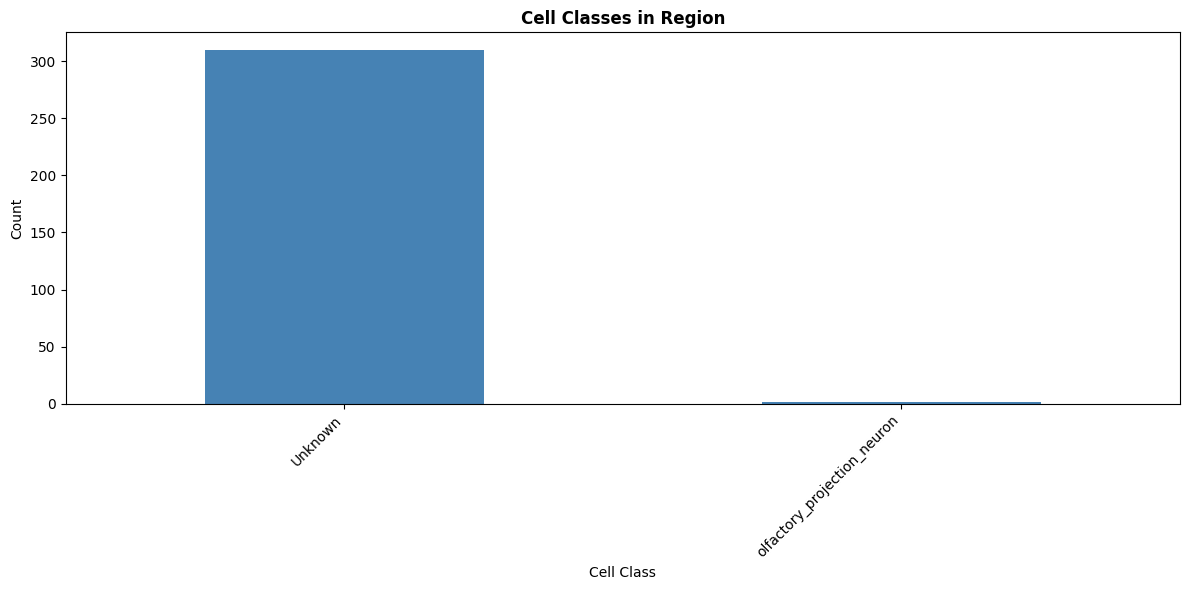


5. Volume analysis:
   Root 576460752499537597: 38 voxels = 0.00 µm³
   Root 576460752502187549: 36 voxels = 0.00 µm³
   Root 576460752502203933: 378 voxels = 0.02 µm³
   Root 576460752502220317: 55 voxels = 0.00 µm³
   Root 576460752502236445: 423 voxels = 0.02 µm³


In [20]:
# Scenario: Analyze all neurons in a specific brain region
region_bbox = np.array([
    [center_location[0] - 2000, center_location[0] + 2000],
    [center_location[1] - 2000, center_location[1] + 2000],
    [center_location[2] - 100, center_location[2] + 100]
])

print(f"Analyzing segmentation in region:")
print(f"  X: {region_bbox[0]}")
print(f"  Y: {region_bbox[1]}")
print(f"  Z: {region_bbox[2]}")

# Step 1: Get segmentation cutout
print("\n1. Fetching segmentation cutout...")
cutout, resolution, offset = cp.get_segmentation_cutout(
    region_bbox,
    root_ids=True,
    mip=1,
    coordinates="nm"
)
print(f"   ✓ Cutout shape: {cutout.shape}")

# Step 2: Find all neurons in this region
unique_roots = np.unique(cutout)
unique_roots = unique_roots[unique_roots != 0]
print(f"\n2. Found {len(unique_roots)} neurons in region")

# Step 3: Get annotations for these neurons
if len(unique_roots) > 0 and len(unique_roots) <= 500:  # Limit to reasonable number
    print("\n3. Fetching neuron annotations...")
    region_annotations = cp.get_annotations(unique_roots).groupby('root_id').first().reset_index()
    # annotations may not be available for all neurons
    print(f"   ✓ Retrieved annotations for {len(region_annotations)}/{len(unique_roots)} neurons")
    # fill in missing annotations
    region_annotations = region_annotations[['root_id', 'cell_class', 'cell_type', 'side']]
    region_annotations.fillna('Unknown', inplace=True)
    # convert root_id to int for consistency
    region_annotations['root_id'] = region_annotations['root_id'].astype(np.uint64)

    # add neurons without annotations
    missing_ids = set(unique_roots) - set(region_annotations['root_id'])
    if missing_ids:
        missing_df = pd.DataFrame({'root_id': list(missing_ids), 'cell_class': 'Unknown', 'cell_type': 'Unknown', 'side': 'Unknown'})
        region_annotations = pd.concat([region_annotations, missing_df], ignore_index=True)
        print(f"   ✗ {len(missing_ids)} neurons without annotations added as 'Unknown'")

    # Analyze cell classes
    print("\n4. Cell class distribution:")
    cell_class_counts = region_annotations['cell_class'].value_counts()
    print(cell_class_counts)
    
    # Visualize
    plt.figure(figsize=(12, 6))
    cell_class_counts.plot(kind='bar', color='steelblue')
    plt.title('Cell Classes in Region', fontsize=12, fontweight='bold')
    plt.xlabel('Cell Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Calculate volume occupied by each neuron
    print("\n5. Volume analysis:")
    for root_id in unique_roots[:5]:  # Just first 5
        voxel_count = np.sum(cutout == root_id)
        volume_nm3 = voxel_count * np.prod(resolution)
        volume_um3 = volume_nm3 / 1e9
        print(f"   Root {root_id}: {voxel_count} voxels = {volume_um3:.2f} µm³")
else:
    print(f"\nNote: Too many neurons ({len(unique_roots)}) for detailed analysis")

## 11. Performance Tips and Best Practices

### Tip 1: Cache Supervoxels for Faster Updates

Supervoxels never change, so caching them enables instant ID updates.

In [21]:
import time

neurons_to_track = cp.NeuronCriteria(cell_class='olfactory_projection_neuron', proofread=True).get_roots()[:20]

# Slow: Update without supervoxels
start = time.time()
result_slow = cp.update_ids(neurons_to_track, use_annotations=False, progress=False)
time_slow = time.time() - start
print(f"Update without supervoxels: {time_slow:.2f}s")

# Fast: Get and cache supervoxels once
print("\nCaching supervoxels...")
sv_cache = cp.roots_to_supervoxels(neurons_to_track, progress=False)

# Now use them for updates
start = time.time()
supervoxels_list = [sv_cache[int(rid)][0] for rid in neurons_to_track]  # Use first supervoxel
result_fast = cp.update_ids(neurons_to_track, supervoxels=supervoxels_list, progress=False)
time_fast = time.time() - start
print(f"Update with supervoxels: {time_fast:.2f}s")

print(f"\nSpeedup: {time_slow/time_fast:.1f}x faster with supervoxels!")

Update without supervoxels: 0.18s

Caching supervoxels...
Update with supervoxels: 0.18s

Speedup: 1.0x faster with supervoxels!


### Tip 2: Use Appropriate MIP Levels

Higher MIP = lower resolution = faster queries.

In [22]:
# For different use cases, choose appropriate resolution:

print("Recommended MIP levels:")
print("  mip=0 (highest res): Precise synapse locations, detailed tracing")
print("  mip=1 (lowest res): General morphology, large structures")

# Example: Compare query times
test_bbox = np.array([
    [center_location[0] - 2000, center_location[0] + 2000],
    [center_location[1] - 2000, center_location[1] + 2000],
    [center_location[2] - 100, center_location[2] + 100]
])

for mip in [0, 1]:
    start = time.time()
    cutout, _, _ = cp.get_segmentation_cutout(test_bbox, mip=mip, coordinates="nm")
    elapsed = time.time() - start
    print(f"\nmip={mip}: {cutout.shape} in {elapsed:.2f}s")

Recommended MIP levels:
  mip=0 (highest res): Precise synapse locations, detailed tracing
  mip=1 (lowest res): General morphology, large structures

mip=0: (250, 250, 4) in 2.01s

mip=1: (124, 124, 4) in 1.16s


### Tip 3: Batch Operations

Always process multiple coordinates/IDs in a single call.

In [25]:
# Generate test data
n_locations = 100
test_locations = np.random.randint(
    low=[center_location[0]-5000, center_location[1]-5000, center_location[2]-500],
    high=[center_location[0]+5000, center_location[1]+5000, center_location[2]+500],
    size=(n_locations, 3)
)

# Bad: Loop over locations
start = time.time()
results_slow = []
for loc in test_locations[:10]:  # Just 10 for demo
    result = cp.locs_to_segments([loc], coordinates="nm", progress=False)
    results_slow.append(result[0])
time_slow = time.time() - start
print(f"Loop approach (10 locations): {time_slow:.2f}s")

# Good: Batch processing
start = time.time()
results_fast = cp.locs_to_segments(test_locations[:10], coordinates="nm", progress=False)
time_fast = time.time() - start
print(f"Batch approach (10 locations): {time_fast:.2f}s")

print(f"\nSpeedup: {time_slow/time_fast:.1f}x faster with batching!")
print("\n💡 Always use batch operations for multiple queries!")

Loop approach (10 locations): 10.00s
Batch approach (10 locations): 9.71s

Speedup: 1.0x faster with batching!

💡 Always use batch operations for multiple queries!


## Summary

In this comprehensive deep dive, you learned:

✅ **Hierarchical segmentation** - Root IDs, L2 chunks, and supervoxels  
✅ **Bidirectional conversions** - Between roots and supervoxels  
✅ **Location-based queries** - Finding segments at specific coordinates  
✅ **ID management** - Validating and updating root IDs  
✅ **Neuron mapping** - Connecting spatial reconstructions to segmentation  
✅ **Volume operations** - Extracting segmentation cutouts  
✅ **Voxel-level data** - Working with individual voxels  
✅ **Coordinate correction** - Snapping locations to correct segments  
✅ **Temporal analysis** - Understanding edit history and lineage  
✅ **Practical workflows** - Real-world analysis pipelines  
✅ **Performance optimization** - Tips for efficient queries

### Key Takeaways

1. **Supervoxels are stable** - Cache them for reliable tracking across edits
2. **Root IDs can change** - Always validate and update old IDs
3. **Use appropriate resolution** - Balance speed vs. precision with MIP levels
4. **Batch operations** - Process multiple items together for better performance
5. **Location-based queries** - Essential for connecting spatial data to segmentation
6. **Temporal awareness** - Segmentation is versioned; use timestamps when needed
7. **Coordinate systems matter** - CAVE uses nanometers, CloudVolume uses voxels
8. **CloudVolume has limits** - Limited spatial coverage and resolution; use L2 skeletons/meshes for full neurons

### Common Use Cases

**Synapse analysis**: Use `locs_to_segments` + `snap_to_id` for quality control  
**Neuron tracking**: Use `roots_to_supervoxels` + `update_ids` for stable IDs  
**Region analysis**: Use `get_segmentation_cutout` for local connectivity  
**Quality control**: Use `neuron_to_segments` to validate reconstructions  
**Historical analysis**: Use `get_lineage_graph` + `find_common_time` for temporal studies  
**Voxel operations**: Use `get_voxels` with explicit bounds for small regions

### Important Notes on Voxel Operations

When working with voxel-level data (`get_voxels`, `get_segmentation_cutout`):
- CloudVolume covers only a subset of the full dataset (~360 µm cube)
- Always specify explicit bounds to avoid coverage errors
- Use small regions (< 10 µm) for best performance
- For complete neuron morphology, use `get_l2_skeleton` or `get_mesh` instead